# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install -c conda-forge pyscf
```

## 2025/11/25 にChatGPTで生成したコードを元に自分で試行錯誤

FCI Hamiltonian Shape: (4, 4)

--- Electronic Hamiltonian Matrix ---
[[-1.8304  0.      0.      0.1813]
 [ 0.     -1.0649  0.1813  0.    ]
 [ 0.      0.1813 -1.0649  0.    ]
 [ 0.1813  0.      0.     -0.2545]]

Ground State Energy: -1.13727017 Hartree
HF energy = -1.1166843870853418
K:  [[-1.83043838e+00  5.30891120e-16  4.03215384e-16  1.81288808e-01]
 [ 5.30891120e-16 -1.06494419e+00  1.81288808e-01  1.07187680e-15]
 [ 4.03215384e-16  1.81288808e-01 -1.06494419e+00  5.08289901e-16]
 [ 1.81288808e-01  1.07187680e-15  5.08289901e-16 -2.54503663e-01]]
Number of determinants: 4
Mean projected energy: -1.8348406794553138
shift: -1.968520204284889


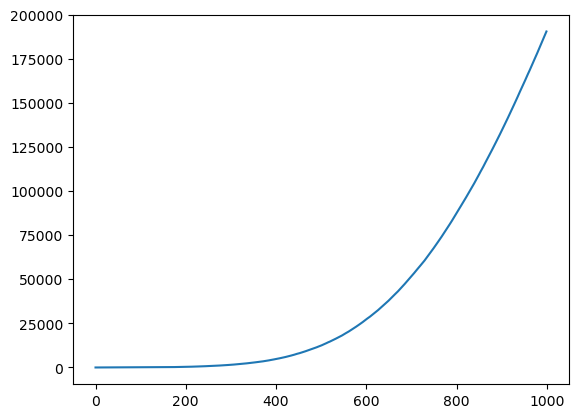

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, fci, ao2mo
from pyscf.fci import direct_spin1

# ===============================
# 1. Build H2 STO-3G Hamiltonian
# ===============================
# 1. 分子定義とRHF計算
mol = gto.M(atom='H 0 0 0; H 0 0 0.7414', basis='sto-3g', unit='A', verbose=0)
mf = scf.RHF(mol).run()

# 2. 積分をMO基底に変換 (ここはどうしても必要です)
h1 = mf.mo_coeff.T @ mf.get_hcore() @ mf.mo_coeff
eri = ao2mo.kernel(mol, mf.mo_coeff)

# 3. 行列の一括取得 (ここが簡略化ポイント)
# pspace関数は、通常「エネルギーの低い重要な配置」だけを選びますが、
# np(抽出数)を十分大きくすれば、全配置のハミルトニアン行列を返します。
norb, nelec = mf.mo_coeff.shape[1], mol.nelec
addr, H_mat = direct_spin1.pspace(h1, eri, norb, nelec, np=1000)

print("FCI Hamiltonian Shape:", H_mat.shape)
print("\n--- Electronic Hamiltonian Matrix ---")
print(np.array_str(H_mat, precision=4, suppress_small=True))

# 固有値確認
e, _ = np.linalg.eigh(H_mat)
print(f"\nGround State Energy: {e[0] + mol.energy_nuc():.8f} Hartree")

E_HF = mf.e_tot
print("HF energy =", E_HF)

# K = H_mat - E_HF * np.eye(H_mat.shape[0])
K = H_mat
print("K: ", K)

dim = K.shape[0]
print("Number of determinants:", dim)

# ==================================
# 2. FCIQMC Simulation (Booth 2009)
# ==================================
n_steps = 1000
delta_tau = 0.01

# Shift parameter (population control)
shift = 0.0
# shift = -1.8  # 適当な負の値にしておく
zeta = 0.01  # ζ in the paper

# Walker population vector (signed integer)
walkers = np.zeros(dim, dtype=float)
target_n_walkers = 1000

# Start with random walker on HF determinant (index 0)
# 本来 {1: [1, -1, 1, ...], 2: [-1, 1, 1, ...]} のようにwalker一つに対して、
# ±1を持つべきだが、annihilation stepにて、対消滅してどちらかの符号しか残らないので整数型で持つ
walkers[0] = 10

pre_pop = 10
population_history = []
energy_estimates = []

rng = np.random.default_rng()

for step in range(n_steps):
    new_walkers = np.zeros(dim)
    
    for i in range(dim):
        n_i = int(abs(walkers[i]))
        sign_i = np.sign(walkers[i])
        if n_i == 0:
            continue

        # --------- Spawning (off-diagonal hopping) ---------
        for _ in range(n_i):
            # randomly choose connected determinant j
            # 論文には遷移先候補をランダムに選ぶとは書いていない
            j = rng.integers(0, dim)
            # Kの非対角要素、かつ0ではない要素からインデックスjを得る
            # targets = [j for j in range(dim) if K[j,i] != 0 and j != i]
            # j = rng.choice(targets)
            # print(j)

            # 遷移確率の分母はFCI行列が2x2のときは常に1
            pgen = 1
            prob = (abs(K[j, i]) * delta_tau) / pgen

            # TODO: probが小さすぎて全くspawnしない
            if rng.random() < prob:
                # K>0なら親と異符号、k<0なら親と同符号のwalkerを生成する
                sign = -np.sign(K[j, i]) * sign_i
                new_walkers[j] += sign

        # --------- Death/Cloning (diagonal contribution) ---------
        diag_term = (K[i, i] - shift)
        death_prob = diag_term * delta_tau
        # print('death_prob: ', death_prob)
            
        for _ in range(n_i):
            if rng.random() < np.abs(death_prob):
                if death_prob > 0:
                    # Pd(death_prob)が正なら、その確率で親walkerを消滅させる
                    walkers[i] -= sign_i
                else:
                    # Pd(death_prob)が負なら、その値の絶対値の確率で親walkerを複製する
                    # 実際にはほとんどcloneされることはない
                    walkers[i] += sign_i

    # --------- Annihilation ---------
    walkers += new_walkers

    # --------- Population Control ---------
    total_pop = np.sum(abs(walkers))
    s_upd_inteval = 5
    if step % s_upd_inteval == 0:
        shift += -zeta/(s_upd_inteval*delta_tau)*np.log(total_pop/pre_pop)
        pre_pop = total_pop

    # --------- Energy Estimator (Projected) ---------
    if walkers[0] != 0:
        E_proj = K[0] @ walkers / walkers[0]
        energy_estimates.append(E_proj)

    population_history.append(total_pop)


# walkerのpopulationの変化をプロット
plt.plot(population_history)
# plt.title("Population of Walkers")
# plt.ylabel("Population")

# ================================
# Output Results
# ================================
# print("\n==== FCIQMC Result ====")
print("Mean projected energy:", np.mean(energy_estimates[-2000:]))
print('shift:', shift)
# print("Exact FCI energy:", cisolver.kernel()[0])


## 2025/11/25 にGeminiで生成したコードを自分で実装調整してみる

一旦このコードで正しく動いているとする。

H_mat:  [[-1.83186365e+00 -5.22608557e-16 -4.67083728e-16  1.81210462e-01]
 [-5.22608557e-16 -1.06466723e+00  1.81210462e-01 -1.64624263e-17]
 [-4.67083728e-16  1.81210462e-01 -1.06466723e+00  8.67705089e-17]
 [ 1.81210462e-01 -1.64624263e-17  8.67705089e-17 -2.52486193e-01]]
Starting FCIQMC for H 0 0 0; H 0 0 0.74...
Hartree-Fock Energy: -1.116759 Ha
shift:  0.0
Step 0: Walkers=10, Shift=0.00000, E_proj=-1.116759
Step 500: Walkers=20, Shift=0.00000, E_proj=-1.116759
Step 1000: Walkers=30, Shift=0.00000, E_proj=-1.116759
Step 1500: Walkers=37, Shift=0.00000, E_proj=-1.116759
Step 2000: Walkers=62, Shift=0.00000, E_proj=-1.119730
Step 2500: Walkers=92, Shift=0.00000, E_proj=-1.124996
Step 3000: Walkers=142, Shift=0.00000, E_proj=-1.131975
Step 3500: Walkers=235, Shift=0.00000, E_proj=-1.134542
Step 4000: Walkers=370, Shift=0.00000, E_proj=-1.139342
Step 4500: Walkers=601, Shift=0.00000, E_proj=-1.139114
Step 5000: Walkers=942, Shift=0.00000, E_proj=-1.138522
Step 5500: Walkers=1410, Shi

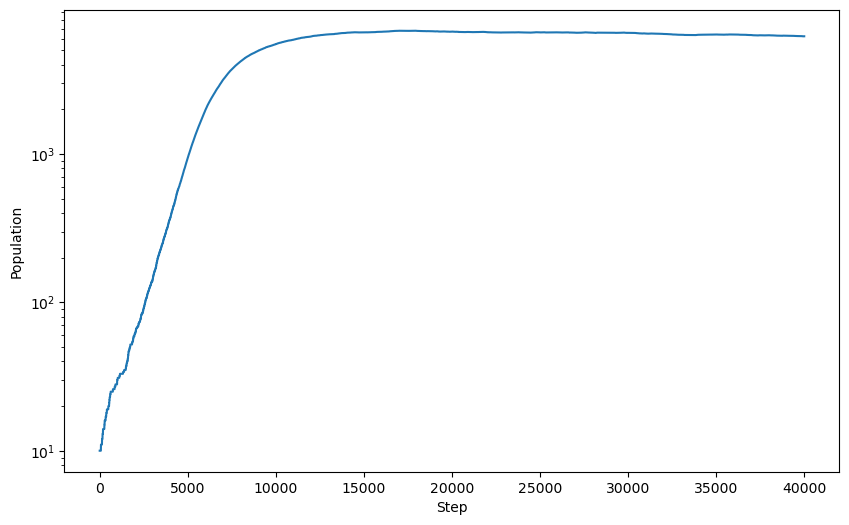

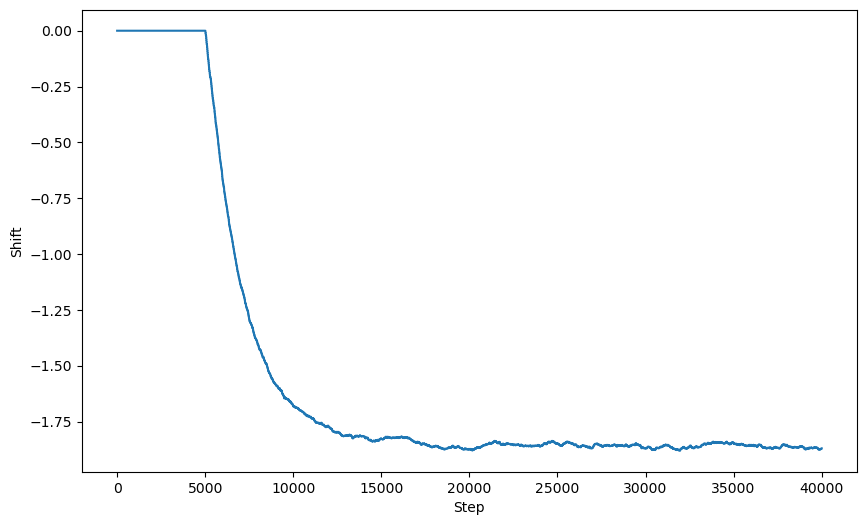

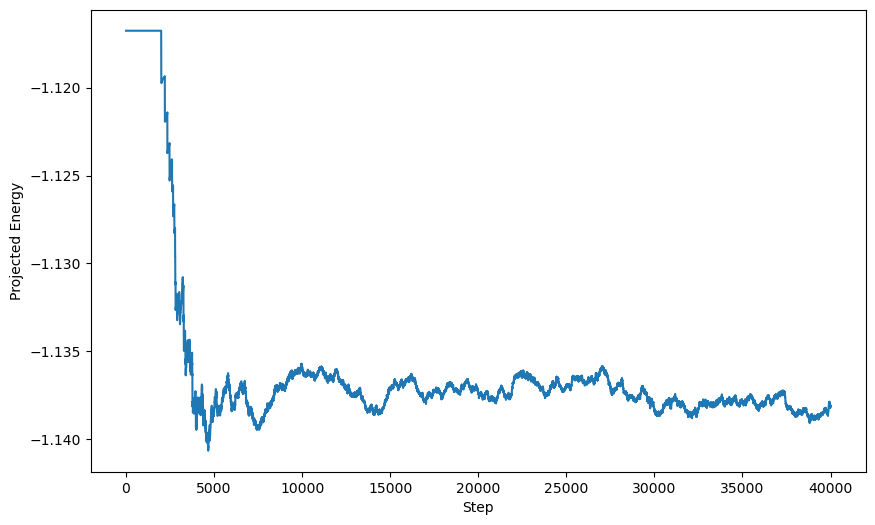

------------------------------
Final FCIQMC Energy: -1.138546 Ha


In [110]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, fci, ao2mo
import random

class SimpleFCIQMC:
    def __init__(self, mol, n_walkers=100, time_step=0.01, steps=5000, damping=0.1):
        self.mol = mol
        self.N_w_target = n_walkers  # 目標ウォーカー数
        self.dt = time_step          # タイムステップ (tau)
        self.steps = steps           # 反復回数
        # self.shift = -1.1            # エネルギーシフト (S)
        self.shift = 0.0             # エネルギーシフト (S)
        self.damping = damping # シフト更新の減衰パラメータ
        self.hist_population = [n_walkers]
        self.hist_shift = [self.shift]
        self.n_walkers = n_walkers
        
        # ハミルトニアン行列の準備
        self.H_mat, self.e_hf, self.norb, self.nelec = self._build_hamiltonian()
        
        # 基底状態（Hartree-Fock解）のインデックスを特定
        # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
        self.ref_det_idx = 0 
        
        # ウォーカーの初期化 {det_index: signed_population}
        # 符号付き整数で管理（+1, -1など）
        self.walkers = {self.ref_det_idx: n_walkers}
        # self.walkers = {self.ref_det_idx: self.N_w_target}
        
        # 統計用
        self.energy_hist = []

    def _build_hamiltonian(self):
        """PySCFを使ってFCIハミルトニアン行列全体を生成する"""
        # 1. RHF計算
        mf = scf.RHF(self.mol).run(verbose=0)
        h1 = mf.get_hcore()
        h2 = mf._eri
        
        # 2. 分子軌道(MO)積分へ変換
        norb = mf.mo_coeff.shape[1]
        nelec = self.mol.nelectron
        h1_mo = np.dot(mf.mo_coeff.T, np.dot(h1, mf.mo_coeff))
        h2_mo = ao2mo.kernel(self.mol, mf.mo_coeff)
        
        # 3. 全CIハミルトニアン行列の生成
        # 注意: H2/STO-3Gのような小規模系でのみ可能です。
        # 大規模系ではオンザフライで行列要素を計算する必要があります。
        cisolver = fci.direct_spin1.FCI(self.mol)
        h2_mo_restore = ao2mo.restore(1, h2_mo, norb)
        H_mat = fci.direct_spin1.pspace(h1_mo, h2_mo_restore, norb, nelec)[1]
        # H_mat = np.array([[-7.13753994e-01, 5.30891120e-16, 4.03215384e-16, 1.81288808e-01],
        #      [ 5.30891120e-16, 5.17401947e-02, 1.81288808e-01, 1.07187680e-15],
        #      [ 4.03215384e-16, 1.81288808e-01, 5.17401947e-02, 5.08289901e-16],
        #      [ 1.81288808e-01, 1.07187680e-15, 5.08289901e-16, 8.62180724e-01]])
        print('H_mat: ', H_mat)
        
        return H_mat, mf.e_tot, norb, nelec

    def run(self):
        print(f"Starting FCIQMC for {self.mol.atom}...")
        print(f"Hartree-Fock Energy: {self.e_hf:.6f} Ha")
        
        diag_H = np.diag(self.H_mat)
        
        # シフトの初期値をHFエネルギー付近に設定（核反発エネルギー込み）
        # H_matは電子ハミルトニアンなので、核反発を加える必要があるが、
        # ここではダイナミクスのためにH_matの基底期待値に合わせる
        # self.shift = diag_H[self.ref_det_idx]
        print('shift: ', self.shift)
        pre_shift = self.shift
        pre_pop = self.n_walkers
        
        for step in range(self.steps):
            new_walkers = {}
            
            # --- 1. Spawning & Death/Cloning Step ---
            # 現在の全ウォーカーに対してループ
            current_dets = list(self.walkers.keys())
            
            for i in current_dets:
                n_i = self.walkers[i] # 決定基i上のウォーカー数（符号付き）
                if n_i == 0: continue
                
                # A. Diagonal Step (Death/Cloning)
                # Pd = exp(-dt * (H_ii - S)) - 1  ~ -dt * (H_ii - S)
                # ここでは単純な一次近似を使用
                h_ii = diag_H[i]
                prob_death = self.dt * (h_ii - self.shift)
                # 既存のウォーカー数 n_i を増減させる
                # 確率的に床関数/天井関数を使って整数化
                change = -(n_i * prob_death)                
                # 確率的整数化 (Stochastic rounding)
                change_int = int(change)
                if random.random() < abs(change - change_int):
                    change_int += int(np.sign(change))
                
                # 生き残ったウォーカーを一時リストに追加
                if i not in new_walkers: new_walkers[i] = 0
                new_walkers[i] += n_i + change_int

                # B. Off-Diagonal Step (Spawning)
                # 決定基 i から j へのスポーニング
                # 通常は接続された決定基をランダムサンプリングするが、
                # ここでは行列が小さいため、接続している全 j を走査（簡単のため）
                row = self.H_mat[i]
                # 非ゼロ要素のインデックスを取得（自分自身を除く）
                connected_dets = np.where(row != 0)[0]
                
                for j in connected_dets:
                    if i == j: continue
                    h_ij = row[j]
                    
                    # Spawning probability: Ps = dt * |H_ij|
                    # 生成される数: sign(walker) * sign(-H_ij)
                    prob_spawn = self.dt * abs(h_ij)
                    n_spawn = abs(n_i) * prob_spawn
                    
                    # 確率的整数化
                    n_spawn_int = int(n_spawn)
                    if random.random() < (n_spawn - n_spawn_int):
                        n_spawn_int += 1
                    
                    if n_spawn_int > 0:
                        # 符号の決定 (反対称性を考慮: H_ij < 0 なら同符号、H_ij > 0 なら異符号)
                        child_sign = np.sign(n_i) * -np.sign(h_ij)
                        
                        if j not in new_walkers: new_walkers[j] = 0
                        new_walkers[j] += int(child_sign * n_spawn_int)

            # --- 2. Annihilation Step ---
            # new_walkers辞書への加算処理ですでに、同じ決定基上の
            # 正負のウォーカーは相殺（Annihilation）されている。
            # 数が0になった決定基を削除
            self.walkers = {k: v for k, v in new_walkers.items() if v != 0}
            
            # --- 3. Shift Update ---
            total_walkers = sum(abs(w) for w in self.walkers.values())
            if step > 5000: # 初期緩和後
                shift_upd_int = 10
                if step % shift_upd_int == 0:
                    self.shift = pre_shift - (self.damping / (shift_upd_int*self.dt)) * np.log(total_walkers / pre_pop)
                    # self.shift = pre_shift - (self.damping / (shift_upd_int*self.dt)) * np.log(total_walkers / self.N_w_target)
                    pre_shift = self.shift
            self.hist_shift.append(self.shift)
            pre_pop = total_walkers
            self.hist_population.append(total_walkers)
            
            
            # --- 4. Energy Estimation (Projected Energy) ---
            # E = <D0|H|Psi> / <D0|Psi>
            # HF決定基(D0)上のウォーカー数と、D0からつながるH要素で計算
            
            num_ref = self.walkers.get(self.ref_det_idx, 0)
            if num_ref != 0:
                # Hの対角成分（D0のエネルギー）
                energy_proj = diag_H[self.ref_det_idx]
                
                # Hの非対角成分からの寄与 (sum_{j!=0} H_0j * N_j) / N_0
                off_diag_sum = 0
                row0 = self.H_mat[self.ref_det_idx]
                for det_idx, n_w in self.walkers.items():
                    if det_idx != self.ref_det_idx:
                        off_diag_sum += row0[det_idx] * n_w
                
                energy_proj += off_diag_sum / num_ref
                
                # 核反発エネルギーを足して全エネルギーへ
                total_energy = energy_proj + self.mol.energy_nuc()
                self.energy_hist.append(total_energy)
            
            if step % 500 == 0:
                print(f"Step {step}: Walkers={total_walkers}, Shift={self.shift:.5f}, E_proj={self.energy_hist[-1] if self.energy_hist else 0:.6f}")

        return np.mean(self.energy_hist[-1000:]) # 最後の1000ステップの平均

# --- 実行 ---
# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)

# FCIQMCの実行
fci_qmc = SimpleFCIQMC(mol, n_walkers=10, time_step=0.0005, steps=40000, damping=0.05)
fci_energy = fci_qmc.run()

print(fci_qmc.hist_population[0])

plt.figure(figsize=(10, 6))
plt.plot(fci_qmc.hist_population)
plt.xlabel('Step')
plt.ylabel('Population')
plt.yscale('log')

plt.figure(figsize=(10, 6))
plt.plot(fci_qmc.hist_shift)
plt.xlabel('Step')
plt.ylabel('Shift')

plt.figure(figsize=(10, 6))
plt.plot(fci_qmc.energy_hist)
plt.xlabel('Step')
plt.ylabel('Projected Energy')

plt.show()

# 正解値（厳密な対角化）との比較
print("-" * 30)
print(f"Final FCIQMC Energy: {fci_energy:.6f} Ha")

# PySCFの厳密解(FCI)
# cisolver = fci.FCI(mol, scf.RHF(mol).run(verbose=0))
# print(f"Exact FCI Energy   : {cisolver.kernel()[0]:.6f} Ha")